<a href="https://colab.research.google.com/github/SiweiMa/concrete_ml_lab/blob/main/prediction_of_concrete_strength.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection    import train_test_split, ParameterSampler, RandomizedSearchCV
from sklearn.base               import TransformerMixin, BaseEstimator, clone
from sklearn.ensemble           import *
from sklearn.metrics            import mean_squared_error, make_scorer
from sklearn.pipeline           import Pipeline, make_pipeline
from sklearn.preprocessing      import *
from sklearn.impute             import *
from sklearn.compose            import *
from sklearn.feature_selection  import SelectFromModel
from sklearn.decomposition      import PCA
from sklearn.linear_model       import Lasso, LinearRegression
from sklearn                    import tree

In [3]:
# credit: https://www.kaggle.com/jankoch/scikit-learn-pipelines-and-pandas

class DropAllZeroTrainColumnsTransformer(BaseEstimator, TransformerMixin):
    """ A DataFrame transformer that provides dropping all-zero columns
    """

    def transform(self, X, **transformparams):
        """ Drops certain all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        
        Returns
        ----------
        trans : DataFrame
        """
        
        trans = X.drop(self.cols_, axis=1).copy()
        return trans

    def fit(self, X, y=None, **fitparams):
        """ Determines the all-zero columns of X
        
        Parameters
        ----------
        X : DataFrame
        y : not used
        
        Returns
        ----------
        self : object
        """
        
        self.cols_ = X.columns[(X==0).all()]
        return self

In [4]:
def avg_coefficient_of_variation(test_1, test_2):
  """
  According to ASTM C39/C39M, the acceptable range of 2 cylinder strengths is 9.0% 
  for 4 by 8 inch cylinder concrete samples in laboratory conditon by single-operator.
  Thus, we consider the target true strength as the strength of the first test
  and the predicted strength as the one of the second test.
  """
  mean = (test_1 + test_2) / 2
  sqrt = np.sqrt(((test_1 - mean) ** 2 +  (test_2 - mean) ** 2))
  return np.mean(sqrt / mean * 100)

# make the metrics to be scorer for sklearn
coefficient_of_variation_scorer = make_scorer(avg_coefficient_of_variation)

# **Data**

In [5]:
data = pd.read_csv('concrete_data.csv')

In [6]:
y = data.loc[:, '28-d']
X = data.drop('28-d', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# **Feature Engineering and Algorithm Search in Pipeline**

In [7]:
# prepare algorithms
algorithms = []
algorithms.append(Lasso())
algorithms.append(RandomForestRegressor())
algorithms.append(ExtraTreesRegressor())

# prepare hyperparameters
hyperparameters = []

hyperparameters_lasso = {
                        'lasso__alpha': np.linspace(0, 1, 10), # strength of regulation, when alpha = 0, lasso degrade to regular linear regression
                        'lasso__max_iter': [1000, 10000, 100000], # iteration to find the minimum point
                        }

hyperparameters_rf = {
                      'randomforestregressor__n_estimators': [50, 70, 100, 150, 200, 300], # due to the bootstrapping, one tree only see a subset of data, thus we need to try multiple trees
                      'randomforestregressor__max_depth': [6,9, None], # set the max_depth to prevent the random forest to be too deep to prevent overfitting
                      'randomforestregressor__min_samples_leaf': [1,2,3,4,5] # also prevent the random forest goes too specific and prevent over-fitting
                     }       

hyperparameters_etr = {
                      # ExtraTreesRegressor is a modfied version of random forest. Instead of bootstrapping, it uses all data and randomly select one split
                      'extratreesregressor__n_estimators': [50, 70, 100, 150, 200, 300],
                      'extratreesregressor__max_depth': [6,9, None],
                      'extratreesregressor__min_samples_leaf': [1,2,3,4,5],
                      }

hyperparameters.append(hyperparameters_lasso)
hyperparameters.append(hyperparameters_rf)
hyperparameters.append(hyperparameters_etr)


#### Causion! The next cell would take some time to run
It performs three different algorithms and their corresponding hyperparamter space, and two evaluation metrics with randomized search by using cross validation.

In [8]:
best_score_coefvar = []
best_score_rmse = []
all_models = []
scorings = [coefficient_of_variation_scorer, 'neg_root_mean_squared_error']

for i, algorithm in enumerate(algorithms):
    for scoring in scorings:
        pipe = make_pipeline(# some features only have zeros, which has no information, thus drop these features
                            DropAllZeroTrainColumnsTransformer(), 
                            # all the variables are numeric, and all missing values are in the form of np.nan. 
                            # to avoid the change of distribution of the feature, we use strategy as median
                            SimpleImputer(missing_values=np.nan, strategy='median'), 
                            # for Lasso algorithm, we need standarize the data at first
                            StandardScaler(),
                            # apply algorithm
                            algorithm
                            )

        regressor_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                          param_distributions=hyperparameters[i], 
                                          n_iter=20, 
                                          cv=5, 
                                          n_jobs=-1,
                                          verbose=False,
                                          scoring=scoring,
                                        )
        
        regressor_rand_cv.fit(X_train, y_train)
        all_models.append(regressor_rand_cv)

        if scoring == 'neg_root_mean_squared_error':
            best_score_rmse.append(regressor_rand_cv.cv_results_['mean_test_score'])
        else:
            best_score_coefvar.append(regressor_rand_cv.cv_results_['mean_test_score'])

In [9]:
best_score_coefvar_concat = np.concatenate((best_score_coefvar[0].reshape(-1,1), best_score_coefvar[1].reshape(-1,1), best_score_coefvar[2].reshape(-1,1)), axis=1)
best_score_rmse_concat = np.concatenate((best_score_rmse[0].reshape(-1,1), best_score_rmse[1].reshape(-1,1), best_score_rmse[2].reshape(-1,1)), axis=1)


**Evaluation Metrics:**

1) Coefficient of Variation

It is a customized evalution metric. It is commonly used for concrete strength test and it represents the repeatablity of the strength test. If our prediction by machine learning algorithms can reach the range (<9.0%) by American Society for Testing and Materials (ASTM), it means that our predictions are comparable to the lab test.

2) RMSE

Commonly used metric. It penalizes the outlier heavier compared with MAE as it squared the error term which inflate the value of large error.

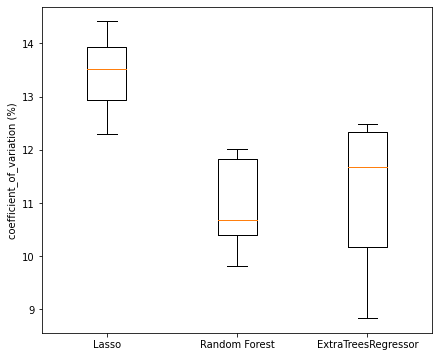

In [10]:
fig, ax = plt.subplots(1, figsize=(7,6))
ax.boxplot(best_score_coefvar_concat)
# ax.set_xlabel('y_pred')
ax.set_ylabel('coefficient_of_variation (%)')
ax.set_xticklabels(['Lasso', 'Random Forest', 'ExtraTreesRegressor'])
plt.show()

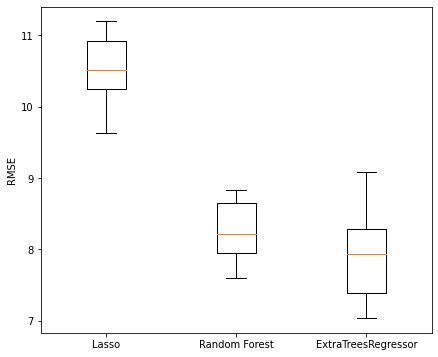

In [11]:
fig, ax = plt.subplots(1, figsize=(7,6))
ax.boxplot(-best_score_rmse_concat)
# ax.set_xlabel('y_pred')
ax.set_ylabel('RMSE')
ax.set_xticklabels(['Lasso', 'Random Forest', 'ExtraTreesRegressor'])
plt.show()

As we can see that Lasso performed worse than the other two algorithms by Coefficient of Variation and RMSE. Random Forest and Extra Trees Regressor shows the comparable metrics values but Random Forest has narrower variance. Thus, we selected Random Forest as our final model.

# **Results/Conclusion**


### All pipeline steps of the best model

In [12]:
from sklearn import set_config

set_config(display='diagram')

best_model_by_randcv = all_models[3]
best_model_pipe = best_model_by_randcv.best_estimator_
best_model_pipe

Pipeline(steps=[('dropallzerotraincolumnstransformer',
                 DropAllZeroTrainColumnsTransformer()),
                ('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=200))])

### All non-default hyperparameters - turns out most hyperparameters are equal to the defualt ones

In [13]:
best_model_pipe['randomforestregressor']

RandomForestRegressor(n_estimators=200)

### Final model parameters

In [14]:
best_model_pipe['randomforestregressor'].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 200,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Model Explanation

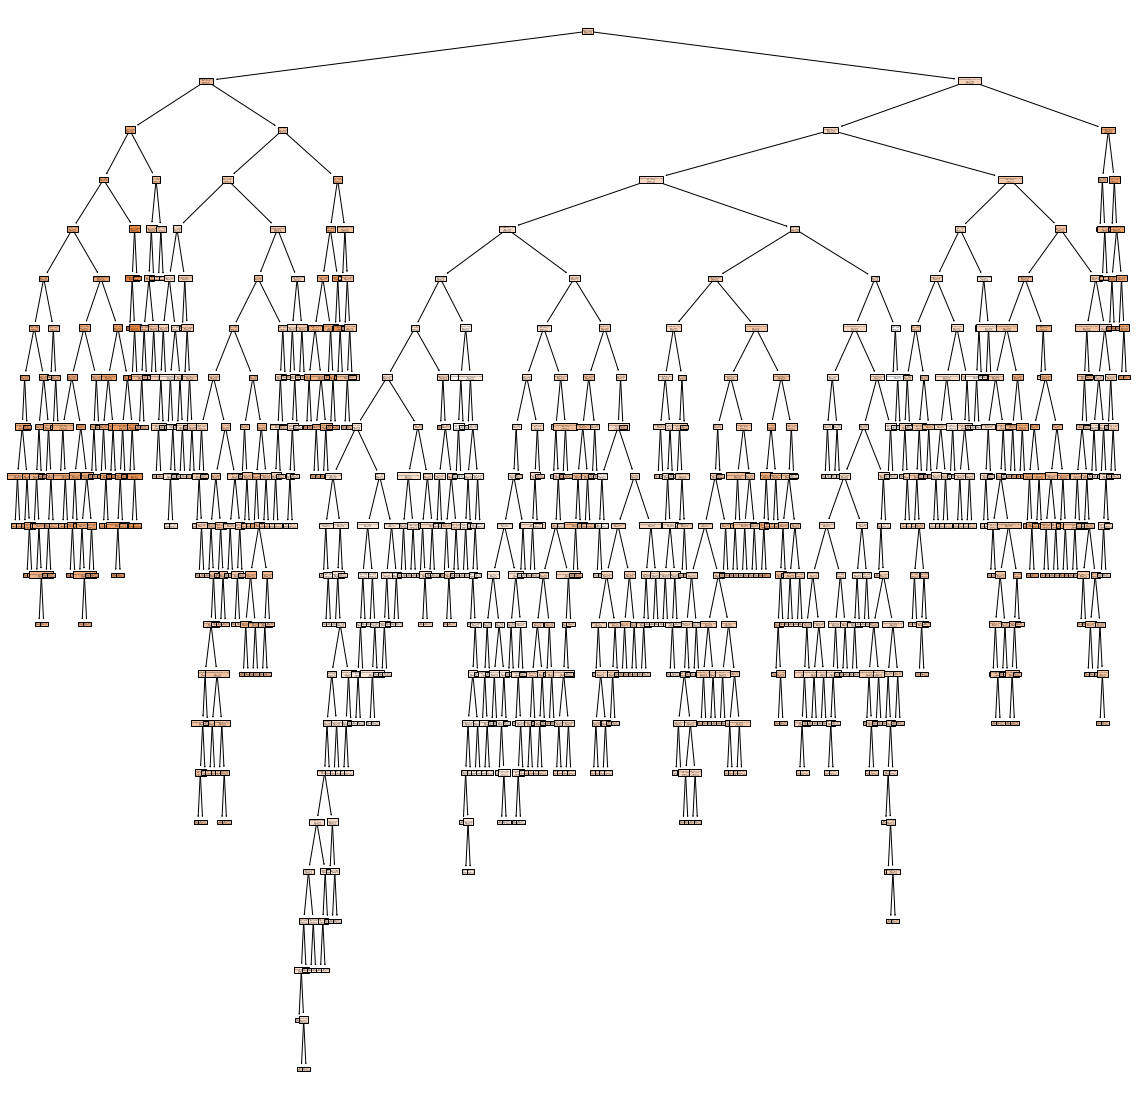

In [15]:
plt.figure(figsize=(20,20))
_ = tree.plot_tree(best_model_pipe['randomforestregressor'].estimators_[0], feature_names=DropAllZeroTrainColumnsTransformer().fit(X).transform(X).columns, filled=True)

By training bootstrapped data, random forest ensemble a bag of decision tress. In this case, the number of decision tree we use is 50. The random forest with 50 trees would have less noise and potentially better performance than a single decision tree. Instead of exhaustively search all the features in decision tree algorithm, random forest only randomly search a subset of features which would futher improve the generaility of the model. Our best model shows that it would have best validation error if it stops search when the samples size per leaf reaches 2.



### Connection to business outcome

With the best model we have, we try to answer question, can machine learning predict the strength of concrete? The prediction by random forest is compared with the test dataset as follows.

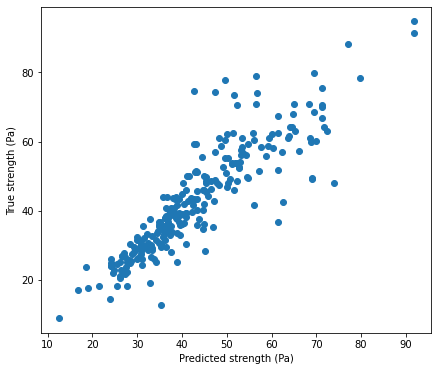

In [16]:
y_pred = best_model_by_randcv.predict(X_test)

fig, ax = plt.subplots(1, figsize=(7,6))
ax.scatter(y_pred, y_test)
ax.set_xlabel('Predicted strength (Pa)')
ax.set_ylabel('True strength (Pa)')
plt.show()

In [17]:
print(f"Average coefficient of variation is {avg_coefficient_of_variation(y_test, y_pred):.2f}%")
print(f"RMSE is {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

Average coefficient of variation is 8.14%
RMSE is 7.31


According to ASTM C39/C39M, the acceptable range of coefficient of variation for 2 cylinder strengths is 9.0%.

Our average coefficient of variation is within this recommended range which means that the prediction by machine learning can serve as a good indicator for the strength of concrete if it cannot replace the lab test.

## Next steps



1. Dive deep into the best model and figure out why it works reasonable well. 

The random forest identify that specific surface area of metakaolin (MK) is most important feature. It makes sense to me because we know that metakaolin with high spefici surface area would greatly enhance the chemical reaction inside the concrete and therefore increase the strength of concrete. But some feature may less sense to me, such as amount of K2O in cement. It may find some important features and shed some light into the research of concrete material but it is also possible that it is due to the relative small and less representative data set.

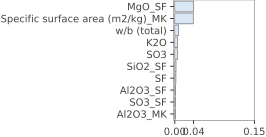

In [18]:
I = importances(best_model_pipe['randomforestregressor'], DropAllZeroTrainColumnsTransformer().fit(X).transform(X), y)
plot_importances(I[:10])

2. Collect larger dataset


3. Based on algorithm search by H2O auto machine learning, the stacked ensemble of GBM works best which has RMSE of 7.29. It is marginally better than the current models. Due to the time limit, I haven't tried the stacked ensemble technique, which would be one of my next steps. 
